In [90]:
from slim_gsgp_lib.main_slim import slim
from slim_gsgp_lib.utils.utils import train_test_split
from slim_gsgp_lib.evaluators.fitness_functions import rmse
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import time
import os
from tqdm import tqdm
from functions.test_funcs import mape, nrmse, r_squared, mae, standardized_rmse
from matplotlib import pyplot as plt
from slim_gsgp_lib.algorithms.SLIM_GSGP.operators.mutators import *
from slim_gsgp_lib.utils.utils import *
from functions.test_algorithms import *
from functions.random_search import * 
from slim_gsgp_lib.datasets.data_loader import *
import pickle

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

[<function slim_gsgp_lib.datasets.data_loader.load_resid_build_sale_price(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_istanbul(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_airfoil(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_bike_sharing(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_boston(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_breast_cancer(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_concrete_slump(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_concrete_strength(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_diabetes(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_efficiency_heating(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_efficiency_cooling(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_forest_fires(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_ld50(X_y=True)>,
 <functio

In [62]:
from slim_gsgp_lib.initializers.initializers import rhh
from slim_gsgp_lib.algorithms.SLIM_GSGP.representations.individual import Individual
from slim_gsgp_lib.algorithms.SLIM_GSGP.representations.population import Population
from slim_gsgp_lib.algorithms.GP.representations.tree import Tree as GP_Tree
from slim_gsgp_lib.algorithms.GSGP.representations.tree import Tree
from slim_gsgp_lib.utils.utils import protected_div
from slim_gsgp_lib.datasets.data_loader import *
from sklearn.preprocessing import MinMaxScaler
from slim_gsgp_lib.utils.utils import get_terminals
from slim_gsgp_lib.utils.utils import train_test_split
from slim_gsgp_lib.main_slim import slim
import random
import numpy as np 

seed = 0
datasets = [globals()[i] for i in globals() if 'load' in i][2:]
X,y = datasets[2]()
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

example_tree = slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                max_depth=22, init_depth=10, pop_size=5, n_iter=1, seed=seed,
                p_inflate=0.6, p_struct=0.3,
                struct_mutation=True, decay_rate=0.4, p_xo=0, type_structure_mutation='new', verbose=0)

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

TERMINALS = example_tree.collection[0].TERMINALS
FUNCTIONS = example_tree.collection[0].FUNCTIONS
CONSTANTS = example_tree.collection[0].CONSTANTS

population = Population(
            [
                Individual(
                    collection=[
                        Tree(
                            tree,
                            train_semantics=None,
                            test_semantics=None,
                            reconstruct=True,
                        )
                    ],
                    train_semantics=None,
                    test_semantics=None,
                    reconstruct=True,
                )
                for tree in rhh(200, 10, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.1)
            ]
        )

population.calculate_semantics(inputs=X_train, testing=False)

In [53]:
# Import flatten function
from slim_gsgp_lib.algorithms.GP.representations.tree_utils import flatten

In [71]:
struct = population.population[0].structure[0]

In [89]:
def count_elements(structure):
    if isinstance(structure, (tuple, list)):
        return sum(count_elements(item) for item in structure)
    return 1

start = time.time()
for i in range(200):
    count = count_elements(struct)
print(time.time()-start)

start = time.time()
for i in range(200):
    count = len(list(flatten(struct)))  
print(time.time()-start)


0.012662649154663086
0.024825334548950195


In [70]:
struc_mut = structure_mutation(FUNCTIONS, TERMINALS, CONSTANTS, 'new')

for i in range(30):
    offs_pop, depths = [], []
    start = time.time()
    for parent in population.population:
        offs = struc_mut(parent, X_train, max_depth=22, decay_rate=0.05)
        depths.append(offs.depth)
        offs_pop.append(offs)

    print(5*(time.time()-start))
    print(np.mean(depths), np.std(depths))
    population = Population(offs_pop)

4.94516134262085
19.37 2.720863833417615
5.3311991691589355
19.35 2.71983455379183
5.414600372314453
19.26 3.025293374203567
5.730549097061157
18.975 3.5333235062756425
5.208439826965332
18.995 3.588171539935068
6.1056530475616455
19.16 3.4226305672683988
6.221860647201538
19.255 3.1464225717471583
5.787590742111206
19.61 2.7799100704878925
5.547420978546143
19.64 2.7749594591633224
5.688050985336304
19.475 3.034695207100707
5.5388593673706055
19.485 3.0165833321822886
6.388496160507202
19.49 3.0248801629155495
6.011134386062622
19.335 3.2160185011905638
7.303875684738159
19.49 3.0116274670018535
6.212860345840454
19.565 3.0324536270155886
5.631928443908691
19.42 3.0648980407184836
5.8109235763549805
19.385 3.3356820891685706
6.477926969528198
19.555 3.0277012732434487
6.008422374725342
19.525 3.0642087069910886
6.150549650192261
19.44 2.9692423275980695
6.173195838928223
19.53 2.801624528733285
7.054991722106934
19.615 2.6451417731380675
6.160974502563477
19.69 2.596902000461319
6.100

In [3]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

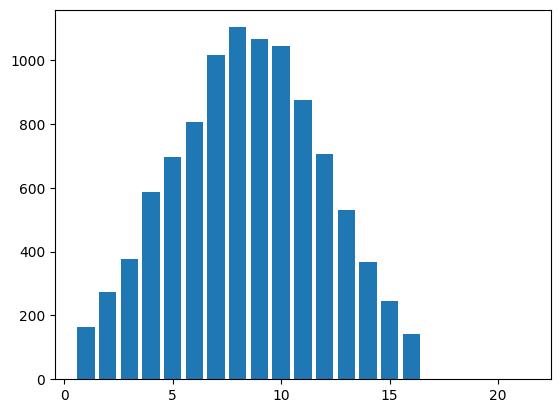

In [4]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

# Example usage
max_depth = 22
random_index = [1, 2,2,2,2,2]  # Example index

depths = []
for i in range(10000):
    depths.append(choose_depth(max_depth, random_index))
    
plt.hist(depths, bins=np.arange(1, max_depth + 1) - 0.5, rwidth=0.8)
plt.show()

In [6]:
seed = 0

X,y = datasets[2]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

example_tree = slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                max_depth=22, init_depth=10, pop_size=50, n_iter=100, seed=seed,
                p_inflate=0.6, p_struct=0.3,
                struct_mutation=True, decay_rate=0.4, p_xo=0, type_structure_mutation='new',)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.304      |      0.303      |      0.145      |        7        |    4167927136   |      5.240      |      5.240      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

In [11]:
constants = example_tree.collection[0].CONSTANTS
functions = example_tree.collection[0].FUNCTIONS
terminals = example_tree.collection[0].TERMINALS
depths = []

for i in range(10000):
    dep = choose_depth(14, [1,1,1,1])
    # dep = random.choice(np.arange(1, 14 + 1))
    # probs = exp_decay_prob(14, 0.3)
    # dep = random.choices(np.arange(1, 14 + 1), weights=probs, k=1)[0]
    if dep == 1:
        depths.append(1)
    else:
        depth = get_random_tree(max_depth=dep, 
                        FUNCTIONS=functions,
                        TERMINALS=terminals,
                        CONSTANTS=constants,
                        p_c=0.1).depth
        
        depths.append(depth)

plt.hist(depths, bins=np.arange(1, 14 + 1) - 0.5, rwidth=0.8)
plt.show()

AttributeError: 'Population' object has no attribute 'collection'

In [15]:
indices_with_levels = get_indices_with_levels(example_tree.structure[0])
valid_indices_with_levels = [(index, level) for index, level in indices_with_levels if 22 - len(index) >= 2]


valid_indices, valid_levels = zip(*valid_indices_with_levels)
probs = exp_decay_prob(max(valid_levels) + 1, decay_rate=0.2)
level_probs = [probs[level] for level in valid_levels]
random_index = random.choices(valid_indices, weights=level_probs)[0]

In [4]:
indices_list = get_indices_with_levels(example_tree.structure[0])

In [5]:
get_indices_with_levels(example_tree.structure[0])

[((1,), 1),
 ((1, 1), 2),
 ((1, 2), 2),
 ((1, 2, 1), 3),
 ((1, 2, 2), 3),
 ((1, 2, 2, 1), 4),
 ((1, 2, 2, 2), 4),
 ((1, 2, 2, 2, 1), 5),
 ((1, 2, 2, 2, 2), 5),
 ((1, 2, 2, 2, 2, 1), 6),
 ((1, 2, 2, 2, 2, 2), 6),
 ((1, 2, 2, 2, 2, 2, 1), 7),
 ((1, 2, 2, 2, 2, 2, 2), 7),
 ((1, 2, 2, 2, 2, 2, 2, 1), 8),
 ((1, 2, 2, 2, 2, 2, 2, 1, 1), 9),
 ((1, 2, 2, 2, 2, 2, 2, 1, 2), 9),
 ((1, 2, 2, 2, 2, 2, 2, 2), 8),
 ((1, 2, 2, 2, 2, 2, 2, 2, 1), 9),
 ((1, 2, 2, 2, 2, 2, 2, 2, 2), 9),
 ((2,), 1)]

In [14]:
exp_decay_prob(5, decay_rate=0.3)

array([0.10048537, 0.13564106, 0.18309628, 0.24715412, 0.33362317])

In [16]:
decay_prob

array([0.00026134, 0.00028883, 0.0003192 , 0.00035277, 0.00038987,
       0.00043088, 0.00047619, 0.00052628, 0.00058162, 0.00064279,
       0.0007104 , 0.00078511, 0.00086768, 0.00095894, 0.00105979,
       0.00117125, 0.00129443, 0.00143056, 0.00158102, 0.00174729,
       0.00193106, 0.00213415, 0.0023586 , 0.00260666, 0.0028808 ,
       0.00318378, 0.00351862, 0.00388868, 0.00429765, 0.00474964,
       0.00524916, 0.00580122, 0.00641134, 0.00708563, 0.00783083,
       0.00865441, 0.0095646 , 0.01057052, 0.01168223, 0.01291086,
       0.0142687 , 0.01576936, 0.01742784, 0.01926074, 0.02128641,
       0.02352512, 0.02599927, 0.02873364, 0.03175559, 0.03509535,
       0.03878636, 0.04286556, 0.04737377, 0.05235611, 0.05786245,
       0.0639479 , 0.07067336, 0.07810614, 0.08632063, 0.09539905])

In [17]:
counts_dict = {}

for i in range(10000):
    random_index = random.choices(indices_list, weights=decay_prob)[0]
    if random_index in counts_dict:
        counts_dict[random_index] += 1
    else:
        counts_dict[random_index] = 1

In [18]:
counts_dict

{(2, 2, 2, 2, 2): 929,
 (2, 1, 1, 1, 2): 97,
 (1, 2, 1): 15,
 (2, 1, 2, 2, 2): 267,
 (2, 2, 1): 317,
 (2, 1, 2, 1, 2): 195,
 (2, 2, 1, 2, 1): 426,
 (2, 2, 2, 2): 802,
 (2, 2, 2, 2, 1): 887,
 (2, 2, 2): 535,
 (1, 2, 2): 38,
 (2, 2, 1, 2): 409,
 (2, 2, 1, 2, 2): 467,
 (2, 1, 2, 1, 1): 163,
 (2, 2, 2, 1): 578,
 (2, 2): 297,
 (2, 2, 1, 1): 337,
 (2, 1, 2, 1): 177,
 (2, 2, 2, 1, 2): 712,
 (2, 1, 1, 2, 1): 103,
 (2, 1, 2): 140,
 (2, 2, 2, 1, 1): 603,
 (1, 2, 1, 1, 2): 12,
 (1, 2): 10,
 (1, 2, 2, 1, 2): 43,
 (2, 1, 2, 2, 1): 217,
 (1, 2, 2, 2, 1): 45,
 (2, 1): 55,
 (2, 1, 1, 2, 2): 118,
 (2, 1, 1): 76,
 (2, 1, 2, 2): 203,
 (2, 1, 1, 1, 1): 81,
 (1, 2, 2, 2, 2): 58,
 (1, 2, 1, 2, 2): 21,
 (1, 2, 1, 1, 1): 17,
 (1, 1, 1): 8,
 (1, 1, 1, 2, 1): 7,
 (2, 1, 1, 1): 80,
 (1, 2, 2, 1, 1): 40,
 (1, 2, 2, 1): 31,
 (2, 1, 1, 2): 117,
 (2,): 64,
 (1, 1): 3,
 (1, 1, 1, 2): 10,
 (1, 2, 2, 2): 42,
 (1, 1, 2, 2): 12,
 (1, 2, 1, 2): 20,
 (1, 1, 2, 1): 6,
 (1, 2, 1, 1): 16,
 (1, 2, 1, 2, 1): 22,
 (1, 1, 2): 9,
